# MNIST(手写数字识别)

In [1]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

In [2]:
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

通常从库里下载的数据集是处理过的，有一些通用关键字：  
1.DESCR 是数据集的描述  
2.data 是数据，行是样本，列是特征  
3.target 是标签

In [3]:
X, y = mnist['data'], mnist['target']
print("X.shape:", X.shape)
print("y.shape:", y.shape)

X.shape: (70000, 784)
y.shape: (70000,)


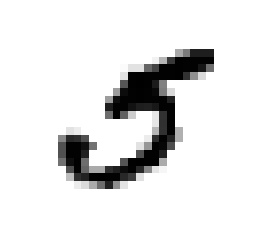

label is: 5.0


In [42]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

def plot_digit(digit):
    digit_image = digit.reshape(28, 28)
    plt.imshow(digit_image, cmap = matplotlib.cm.binary,
        interpolation="nearest")
    plt.axis("off")
    plt.show()

plot_digit(some_digit)
print("label is:", y[36000])

In [5]:
#split train and test sets
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

#因为样本本身有顺序为了方便后面的CV评估，需要打乱顺序
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

#  训练一个二分类器

In [6]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

sgd_clf.predict([some_digit])

array([ True], dtype=bool)

# 模型评估
## CV方法测算正确率

In [7]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.88575,  0.95885,  0.96275])

正确率似乎很高，实际呢，再计算一下一个5都没有的情况下的正确率：

In [8]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.91015,  0.90805,  0.91075])

就是说及时输入一个5都没有，模型的正确率仍然高于90，这种评估方法显然不适用于非均匀的情况

## 混淆矩阵(Confusion Matrix)

In [9]:
#为了计算混淆矩阵，需要将模型的预测值与数据集真实值比较

from sklearn.cross_validation import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

G:\machine-learn\anaconda\envs\tensorflow\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


array([[51962,  2617],
       [ 1236,  4185]])

理想情况下混淆矩阵应该是一个对角阵，

\begin{equation*}
precision = TP/(TP+FP)
\end{equation*}
\begin{equation*}
recall = TP/(TP+FN)
\end{equation*}
\begin{equation*}
F1 = 2/(1/precision+1/recall)
\end{equation*}
sklearn都有相应的分数计算函数

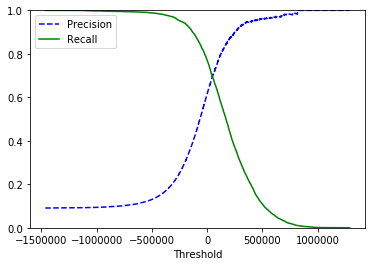

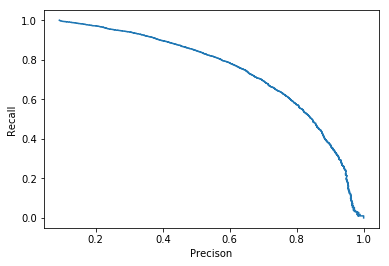

In [10]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_predict

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, 
                             method="decision_function")

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

plt.plot(precisions, recalls)
plt.xlabel("Precison")
plt.ylabel("Recall")
plt.show()

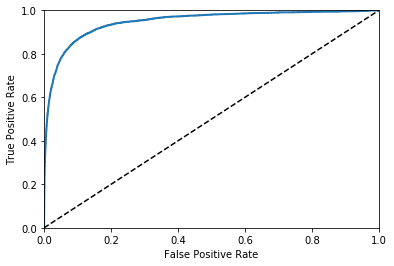

In [11]:
#ROC曲线
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

In [12]:
#使用AUC(area under the curve)得到曲线下方面积
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.94730626079706104

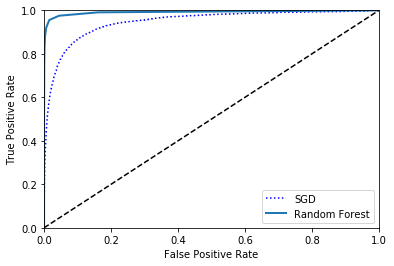

In [13]:
#与随机森林结果比较
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                   method="predict_proba")
#我们只需要正例的概率作为分数
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, 'b:', label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc='lower right')
plt.show()

In [14]:
roc_auc_score(y_train_5, y_scores_forest)

0.9917154235209602

# 多分类(Multiclass Classification)

通常我们的任务是大于2分类的，这时有的算法，比如随机森林和朴素贝叶斯方法是能直接使用的，而线性分类或支持向量机只适用于2分类情形，即便如此还是可以使用多个2分类器实现多分类；  
1.OvA(or OvR)，需要N个，不适用于支持向量机方法
2.OvO,但是需要N*(N-1)/2个  

Scikit-learn自动检测，当用户尝试将一个2分类算法应用与多分类情形时，自动套用OvA模式进行分类，比如下例：

In [15]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])
#其实sklearn实施了10个二分类模型，并取出其中最高分数的作为输出

array([ 5.])

In [16]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-300236.44110902, -271611.73053303, -347749.57242102,
        -196837.17577326, -366686.84166274,   50808.17964289,
        -840696.05196625, -298162.03037699, -660881.55310288,
        -575883.75288072]])

也可以强制指定使用OvO或者OvA

In [17]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])
len(ovo_clf.estimators_)

45

# 模型优化
就像我们上一篇说的。下面我们简单地将输入缩放：

In [18]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([ 0.85577884,  0.82159108,  0.86577987])

In [19]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([ 0.91226755,  0.90824541,  0.90943642])

优化了3个百分点！

# 误差分析

首先我们看一下混淆矩阵

In [20]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5744,    2,   17,   12,   11,   41,   44,    8,   38,    6],
       [   2, 6489,   43,   26,    5,   37,    7,    9,  111,   13],
       [  57,   39, 5343,  100,   81,   25,   86,   60,  155,   12],
       [  46,   41,  143, 5366,    3,  218,   37,   52,  133,   92],
       [  20,   29,   35,    9, 5371,    9,   48,   35,   85,  201],
       [  72,   41,   35,  187,   70, 4605,  114,   28,  172,   97],
       [  37,   25,   48,    2,   45,   87, 5619,    6,   49,    0],
       [  20,   25,   68,   31,   67,   12,    7, 5788,   15,  232],
       [  53,  156,   70,  165,   16,  158,   57,   28, 5015,  133],
       [  46,   34,   24,   94,  169,   37,    3,  210,   73, 5259]])

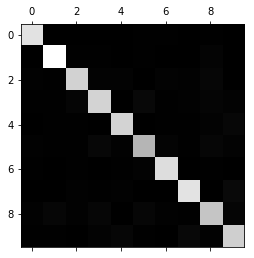

In [21]:
#我们使用图形来看更加直观
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

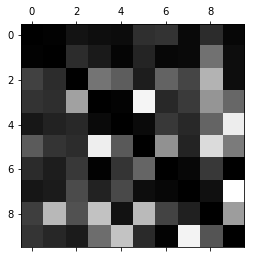

In [22]:
#这样不利于比较，因为上图体现每个元素的绝对值，而对角元素很大，如果我们将他们除以同一个值，就能将他们相比较
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

#使用0值填充对角元素，保留误差值便于分析
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [23]:
#我们看到5和3判别错误比较多，我们可以将它们取出来单独分析：

# 多标签分类
比如识别一个人是谁的时候，我们分类输出就可能是一个2分类的数组，这种情况就叫多标签分类

In [24]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

knn_clf.predict([some_digit])

array([[False,  True]], dtype=bool)

In [25]:
#对这种系统，我们有很多评估手段，主要还是基于实际考虑
#我们可以对上面的模型用F1考量
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
f1_score(y_train, y_train_knn_pred, average="macro")

0.96835888772927081

# 多输出分类
是每项有多个选项的多标签分类，这种模型有些接近回归
比如我们设计一个系统，可以将图片中噪声去除

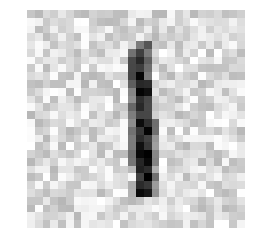

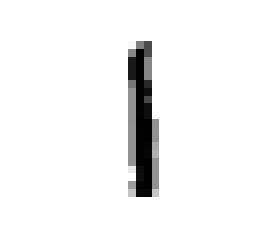

In [44]:
train_noise = np.random.randint(0, 100, (len(X_train), 784))
test_noise = np.random.randint(0, 100, (len(X_test), 784))
X_train_mod = X_train + train_noise
X_test_mod = X_test + test_noise
y_train_mod = X_train
y_test_mod = X_test
plot_digit(X_train_mod[30000])
plot_digit(y_train_mod[30000])

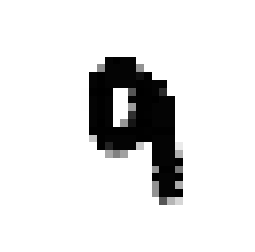

In [49]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[5000]])
plot_digit(clean_digit)